In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps
import cv2
from tqdm import tqdm

In [2]:
def load_data(img_name):
    noise_path = 'stage2_project_data/stage2_rectification/warped_imgs/'+img_name
    clean_path = 'stage2_project_data/stage2_rectification/input_imgs/'+img_name
    
    X_warp = np.array(Image.open(noise_path))/255
    y_true = np.array(Image.open(clean_path))/255
    
    return X_warp, y_true

In [3]:
def img2gray(warped_img, true_img):

    warped_img_uint8 = (warped_img*255).astype(np.uint8)
    true_img_uint8 = (true_img*255).astype(np.uint8)

    gray = cv2.cvtColor(warped_img_uint8, cv2.COLOR_RGB2GRAY)
    gray_true = cv2.cvtColor(true_img_uint8, cv2.COLOR_RGB2GRAY)
    
    return gray, gray_true

In [4]:
# Initialize SIFT detector
def gen_kp_desc(gray, gray_true):
    sift = cv2.SIFT_create()

    # Detect Keypoints and compute Descriptors
    kp_w, descriptors_w = sift.detectAndCompute(gray, None)
    kp_t, descriptors_t = sift.detectAndCompute(gray_true, None)

    return kp_w, descriptors_w, kp_t, descriptors_t

In [6]:
def find_good_desc(descriptors_w, descriptors_t, kp_w, kp_t):
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(descriptors_w,descriptors_t,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    src_pts = np.float32([ kp_w[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_t[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    return src_pts, dst_pts

In [7]:
import largestinteriorrectangle as lir

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def psnr_ssim_rect(orig_img, rectified_img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(rectified_img, cv2.COLOR_BGR2GRAY)
    # Threshold the image to create a binary image (black and white)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    grid = thresh.astype(np.bool)

    rectangle = lir.lir(grid)
    
    (x_min, y_min) = lir.pt1(rectangle)
    (x_max, y_max) = lir.pt2(rectangle)

    # Crop the image using the inscribed rectangle's coordinates
    cropped_img = orig_img[y_min:y_max, x_min:x_max]
    cropped_img_rect = rectified_img[y_min:y_max, x_min:x_max]

    
    psnr_out = psnr(cropped_img, cropped_img_rect)
    ssim_out = ssim(cropped_img, cropped_img_rect, multichannel=True, channel_axis=-1)

    return (psnr_out, ssim_out)

In [8]:
img_names = os.listdir('stage2_project_data/stage2_rectification/warped_imgs')
psnr_all, ssim_all = [], []
for img_name in tqdm(img_names):
    warped_img, true_img = load_data(img_name)
    gray, gray_true = img2gray(warped_img, true_img)
    kp_w, descriptors_w, kp_t, descriptors_t = gen_kp_desc(gray, gray_true)
    src_pts, dst_pts = find_good_desc(descriptors_w, descriptors_t, kp_w, kp_t)
    
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    rect = cv2.warpPerspective(warped_img, M, (warped_img.shape[1], warped_img.shape[0]))
    
    rect_uint8 = (rect*255).astype(np.uint8)
    true_img_uint8 = (true_img*255).astype(np.uint8)
    psnr_out, ssim_out = psnr_ssim_rect(true_img_uint8, rect_uint8)
    psnr_all.append(psnr_out)
    ssim_all.append(ssim_out)
    
print('PSNR: ', np.mean(psnr_all))
print('SSIM: ', np.mean(ssim_all))

  0%|          | 0/11 [00:00<?, ?it/s]C:\Users\tyler\AppData\Local\Temp\ipykernel_20964\2278204297.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  grid = thresh.astype(np.bool)
100%|██████████| 11/11 [00:45<00:00,  4.13s/it]

PSNR:  31.277292626872438
SSIM:  0.9325190920138293


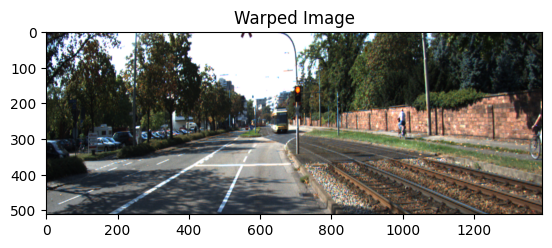

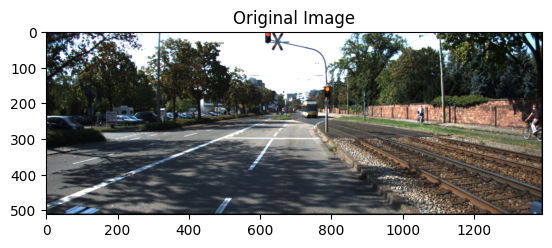

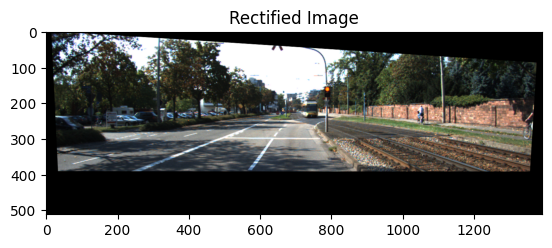

In [11]:
plt.imshow(warped_img)
plt.title('Warped Image')
plt.show()

plt.imshow(true_img)
plt.title('Original Image')
plt.show()

plt.imshow(rect)
plt.title('Rectified Image')
plt.show()